In [1]:
from datasets import load_dataset, load_metric
import pathlib
import shutil
import matplotlib.pyplot as plt

/home/fummicc1/codes/classes/machine_intelligence/Machine-Intelligence-Team-8/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# def clean_ds_name():
#     path = pathlib.Path("data/town/train/Minowacho")
#     for file in list(path.iterdir()):
#         stem = file.stem.replace(".", "")
#         new_file = file.with_stem(stem)
#         file.rename(new_file.as_posix())

In [3]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from typing import *
from torchvision import transforms
from transformers import CLIPProcessor, AutoProcessor

class CLIPDataset(Dataset):
    def __init__(self, data, labels: List[str], transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.processor = AutoProcessor.from_pretrained("geolocal/StreetCLIP")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        text = item["text"]
        image = Image.open(item["image_path"]).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        inputs = self.processor(
            text,
            images=image,
            return_tensors="pt", 
            padding="max_length",
            max_length=max(list(map(lambda x: len(x), self.labels))),
        )
        inputs["input_ids"].squeeze_(dim=0)
        inputs["attention_mask"].squeeze_(dim=0)
        inputs["pixel_values"].squeeze_(dim=0)
        # print("input_ids", inputs["input_ids"].shape)
        # print("attention_mask", inputs["attention_mask"].shape)
        # print("pixel_values", inputs["pixel_values"].shape)        
        return inputs

# Transformations for the image
train_transform = transforms.Compose([
    transforms.CenterCrop(300),    
    transforms.Resize((336, 336)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(
        [
            0.48145466,
            0.4578275,
            0.40821073
        ],
        [
            0.26862954,
            0.26130258,
            0.27577711
        ],
    ),
    transforms.ToPILImage(),
])

val_transform = transforms.Compose([ 
    transforms.Resize((336, 336)),
    transforms.ToTensor(),
    transforms.Normalize(
        [
            0.48145466,
            0.4578275,
            0.40821073
        ],
        [
            0.26862954,
            0.26130258,
            0.27577711
        ],
    ),
    transforms.ToPILImage(),
])

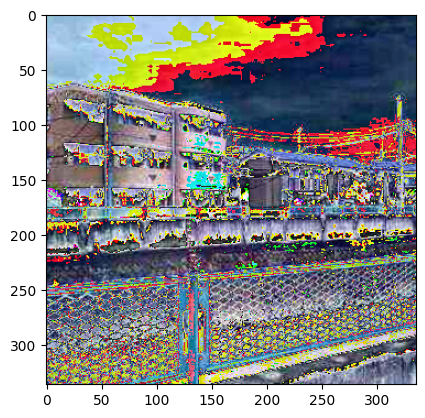

In [4]:
img = Image.open(pathlib.Path('data/town/train/Hiyoshi/3555943276-13964881243.png')).convert('RGB')
img = train_transform(img)
plt.imshow(img)

In [5]:

data = []
val_data = []
label_maps = {
    'Hiyoshi': 'Hiyoshi Kohoku-Toubu',
    'Hiyoshihoncho': 'Hiyoshihoncho Kohoku-Hokubu',
    'Minowacho': 'Minowacho Kohoku-Hokutoubu',
}
labels = {}

folders = list(pathlib.Path("./data/town/train/").iterdir())

for folder in folders:
    folder_name = folder.name
    if folder_name == ".DS_Store":
        continue
    label = label_maps[folder_name]
    labels[label] = len(labels)
    
    file_count = len(list(folder.iterdir()))
    train_count = int(file_count * 0.7)
    for i, file in enumerate(list(folder.iterdir())):
        d = {
            "text": label,
            "image_path": file
        }
        if i < train_count:
            data.append(d)
        else:
            val_data.append(d)

# Initialize the dataset
train_dataset = CLIPDataset(data, labels, train_transform)
val_dataset = CLIPDataset(val_data, labels, val_transform)


In [6]:
def preprocess_logits_for_metrics(preds: torch.Tensor, labels: torch.Tensor):
    # print('preds[0]')
    # preds = list(preds)
    # for i, pred in enumerate(preds):        
    #     print(f'preds[{i}]')
    #     print(pred)
    # if labels is None:
    #     print(f'labels is None')
    # else:
    #     print('labels')
    #     print(labels.shape)
    pass

In [7]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])    
    input_ids = torch.stack([example["input_ids"] for example in examples]).long()
    attention_mask = torch.stack([example["attention_mask"] for example in examples]).long()
    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "return_loss": True,
    }

In [8]:
from transformers import AutoModel, TrainingArguments, Trainer
import evaluate

# Load the model
model = AutoModel.from_pretrained("geolocal/StreetCLIP")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [9]:
batch_size = 4
gpu_cnt = 4
# steps = int(len(train_dataset) / batch_size / gpu_cnt)
# steps = 45
# print('steps:', steps)

# Specify the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    weight_decay=0.01,
    learning_rate=1e-4,
    logging_strategy='epoch',
    # evaluation_strategy='epoch',
    # logging_steps=steps,
    # eval_steps=steps,
)

# Create the Trainer and train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=collate_fn,
)

# Train the model
trainer.train()


/home/fummicc1/codes/classes/machine_intelligence/Machine-Intelligence-Team-8/.venv/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/fummicc1/codes/classes/machine_intelligence/Machine-Intelligence-Team-8/.venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
45,1.480800
90,1.370900
135,1.370900
180,1.370800
225,1.369800


RuntimeError: Input tensor at index 3 has invalid shape [3, 3], but expected [3, 5]

In [10]:
trainer.save_model("./final-model")
model.push_to_hub('hiyoshi-street-clip')

pytorch_model.bin: 100%|██████████| 1.71G/1.71G [02:20<00:00, 12.2MB/s]
Upload 1 LFS files: 100%|██████████| 1/1 [02:20<00:00, 140.87s/it]


CommitInfo(commit_url='https://huggingface.co/fummicc1/hiyoshi-street-clip/commit/e4f87472cdd843c81199eed2499b44e3ea0f6c97', commit_message='Upload model', commit_description='', oid='e4f87472cdd843c81199eed2499b44e3ea0f6c97', pr_url=None, pr_revision=None, pr_num=None)